In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.optim as optim
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def train_model(net,criterion,optimizer,epoch,trainloader,channel,device):
    
        train_loss_list = []
        
        since = time.time()
        for epoch in range(n_epoch):  # loop over the dataset multiple times
            
            training_loss = 0.0  
            for batch_i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data

                if channel != "all":
                    for i,image in enumerate(inputs):

                        x = image ## take image of batch

                        if channel == "red":
                            x[1] = x[0]  ## replace g and b channels with r
                            x[2] = x[0]
                        if channel == "green":
                            x[0] = x[1]  ## replace r and b channels with g
                            x[2] = x[1]
                        if channel == "blue":
                            x[0] = x[2]  ## replace r and g channels with b
                            x[1] = x[2]

                        inputs[i] = x ## replace images

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                training_loss += loss.item()

            print('epoch: %d, loss: %.3f' % (epoch + 1, training_loss/batch_i))
            train_loss_list.append(training_loss/batch_i)

        time_elapsed = time.time() - since
        print('\ntime taken {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Finished Training \n')
        

        return net, train_loss_list

In [3]:
def calc_accuracy(net,testloader,channel,device): 
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data

            if channel != "all":
                for i,image in enumerate(images):
                    x = image ## take image of batch

                    if channel == "red":
                        x[1] = x[0]  ## replace g and b channels with r
                        x[2] = x[0]
                    if channel == "green":
                        x[0] = x[1]  ## replace r and b channels with g
                        x[2] = x[1]
                    if channel == "blue":
                        x[0] = x[2]  ## replace r and g channels with b
                        x[1] = x[2]

                    images[i] = x ## replace images

            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    
    f = open("results.txt", "a")
        
    f.write("\nchannel: %5s \n" % (channel))
    
    print('\nAccuracy of the network on the 10000 test images: %3d %%' % (
        accuracy))
    f.write('Accuracy of the network on the 10000 test images: %3d %% \n' % (
        accuracy))

    f.close()
    return accuracy

In [4]:
def calc_class_accuracy(net,testloader,channel,device,classes):  
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
   
    net.eval()
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            if channel != "all":
                for i,image in enumerate(images):
                    x = image ## take image of batch

                    if channel == "red":
                        x[1] = x[0]  ## replace g and b channels with r
                        x[2] = x[0]
                    if channel == "green":
                        x[0] = x[1]  ## replace r and b channels with g
                        x[2] = x[1]
                    if channel == "blue":
                        x[0] = x[2]  ## replace r and g channels with b
                        x[1] = x[2]

                    images[i] = x ## replace images

            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
 
    f = open("results.txt", "a")
   
    
    se = pd.Series(name = channel,dtype="float64")
    
    for i in range(10):
        class_accuracy = 100 * class_correct[i] / class_total[i]
        f.write('Accuracy of %5s : %3d %% \n' % (
            classes[i],class_accuracy ))
        print('Accuracy of %5s : %3d %%' % (
            classes[i], class_accuracy))
        se.loc[classes[i]] = class_accuracy
    
    f.close()
    return se

In [5]:
## load and transform data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


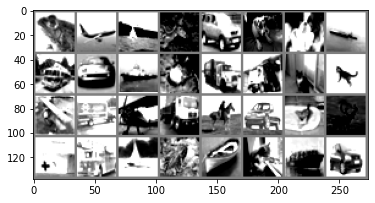

 frog plane  ship  deer   car   dog   dog  ship truck   car  ship  frog truck truck   cat   cat plane truck plane truck horse   car   dog  deer  ship truck  ship  frog  ship   cat  ship   car


In [6]:
## this block is only for visualization of dataset, not necessary for training and evaluation

dataiter = iter(trainloader)
images, labels = dataiter.next()
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

ch = "blue" ## select channel: r,g,b,all

if ch != "all":    
    for i,image in enumerate(images):

        x = image
        if ch == "red":
            x[1] = x[0]  ## replace g and b channels with r
            x[2] = x[0]
        if ch == "green":
            x[0] = x[1]  ## replace r and b channels with g
            x[2] = x[1]
        if ch == "blue":
            x[0] = x[2]  ## replace r and g channels with b
            x[1] = x[2]

        images[i] = x
        
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))


input channel:all

epoch: 1, loss: 1.928
epoch: 2, loss: 1.473
epoch: 3, loss: 1.256
epoch: 4, loss: 1.112
epoch: 5, loss: 0.992
epoch: 6, loss: 0.904
epoch: 7, loss: 0.809
epoch: 8, loss: 0.731
epoch: 9, loss: 0.655
epoch: 10, loss: 0.590

time taken 16m 42s
Finished Training 



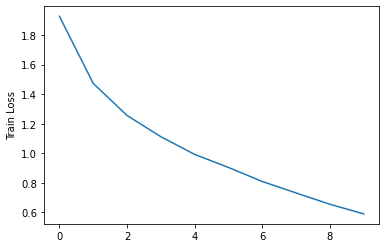


Accuracy of the network on the 10000 test images:  72 %
Accuracy of plane :  75 %
Accuracy of   car :  87 %
Accuracy of  bird :  55 %
Accuracy of   cat :  58 %
Accuracy of  deer :  72 %
Accuracy of   dog :  60 %
Accuracy of  frog :  77 %
Accuracy of horse :  79 %
Accuracy of  ship :  83 %
Accuracy of truck :  70 %

input channel:red

epoch: 1, loss: 2.178
epoch: 2, loss: 1.707
epoch: 3, loss: 1.444
epoch: 4, loss: 1.288
epoch: 5, loss: 1.138
epoch: 6, loss: 1.020
epoch: 7, loss: 0.919
epoch: 8, loss: 0.832
epoch: 9, loss: 0.749
epoch: 10, loss: 0.672

time taken 17m 24s
Finished Training 



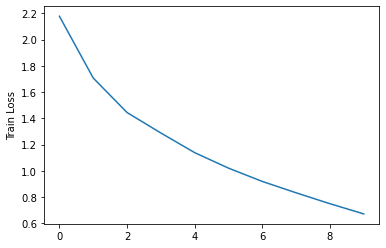


Accuracy of the network on the 10000 test images:  67 %
Accuracy of plane :  70 %
Accuracy of   car :  70 %
Accuracy of  bird :  53 %
Accuracy of   cat :  56 %
Accuracy of  deer :  61 %
Accuracy of   dog :  54 %
Accuracy of  frog :  76 %
Accuracy of horse :  79 %
Accuracy of  ship :  74 %
Accuracy of truck :  75 %

input channel:green

epoch: 1, loss: 2.077
epoch: 2, loss: 1.584
epoch: 3, loss: 1.350
epoch: 4, loss: 1.196
epoch: 5, loss: 1.087
epoch: 6, loss: 0.996
epoch: 7, loss: 0.914
epoch: 8, loss: 0.824
epoch: 9, loss: 0.762
epoch: 10, loss: 0.703

time taken 17m 45s
Finished Training 



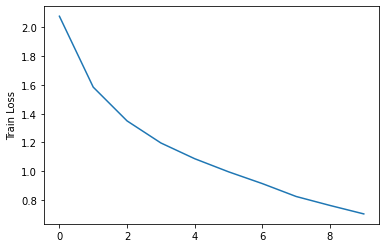


Accuracy of the network on the 10000 test images:  69 %
Accuracy of plane :  64 %
Accuracy of   car :  78 %
Accuracy of  bird :  64 %
Accuracy of   cat :  53 %
Accuracy of  deer :  60 %
Accuracy of   dog :  54 %
Accuracy of  frog :  83 %
Accuracy of horse :  75 %
Accuracy of  ship :  80 %
Accuracy of truck :  78 %

input channel:blue

epoch: 1, loss: 2.086
epoch: 2, loss: 1.595
epoch: 3, loss: 1.364
epoch: 4, loss: 1.196
epoch: 5, loss: 1.083
epoch: 6, loss: 0.978
epoch: 7, loss: 0.898
epoch: 8, loss: 0.821
epoch: 9, loss: 0.750
epoch: 10, loss: 0.679

time taken 17m 52s
Finished Training 



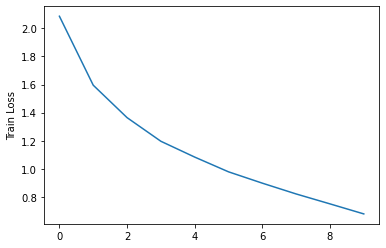


Accuracy of the network on the 10000 test images:  69 %
Accuracy of plane :  70 %
Accuracy of   car :  78 %
Accuracy of  bird :  53 %
Accuracy of   cat :  66 %
Accuracy of  deer :  62 %
Accuracy of   dog :  54 %
Accuracy of  frog :  76 %
Accuracy of horse :  70 %
Accuracy of  ship :  79 %
Accuracy of truck :  80 %


In [7]:
from IPython.display import clear_output
## train and evaluate

n_epoch = 10
channel = ["all","red","green","blue"]  

df = pd.DataFrame(columns=classes)

for ch in channel:
    #clear_output(wait=True)
    ## initialize network

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = resnet18(num_classes=10)

    net.to(device)
    
    ## initialize loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=9e-1)
    
    print("\ninput channel:" + ch + "\n" )
    ## train network
    trained_net, train_loss_list = train_model(net,criterion,optimizer,n_epoch,trainloader,ch,device)   
    
     ## plot training loss
    plt.plot(train_loss_list)
    plt.ylabel('Train Loss')
   
    plt.savefig("train_loss_" + ch + ".png")
    plt.show()

    
    ## calc overall accuracy
    calc_accuracy(trained_net,testloader,ch,device)

    ## calc accuracy for each class
    se = calc_class_accuracy(trained_net,testloader,ch,device,classes)
    
    df = df.append(se)

In [8]:
df.index.name = "input channel"
df

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
input channel,,,,,,,,,,
all,75.5,87.7,55.1,58.0,72.7,60.8,77.9,79.6,83.9,70.7
red,70.1,70.6,53.3,56.1,61.3,54.1,76.7,79.6,74.6,75.5
green,64.0,78.8,64.1,53.2,60.0,54.6,83.5,75.8,80.2,78.2
blue,70.7,78.9,53.2,66.4,62.7,54.0,76.8,70.3,79.2,80.5


In [9]:
df.to_csv('class_accuracy.csv')